# Detection and Classification of Military Planes: A Comparative Study of CNN, YOLO, Faster R-CNN, RetinaNet, and EfficientDet


---

In the midst of the ongoing war in Ukraine, the ability to accurately detect and classify military aircraft is of critical importance for surveillance, defense, and strategic planning. This capability can significantly contribute to national security and defense efforts.

Traditionally, image recognition tasks have relied on simple Convolutional Neural Networks (CNNs) for their relatively straightforward architecture and ease of implementation. However, with the availability of more complex models such as YOLO (You Only Look Once), Faster R-CNN, RetinaNet, and EfficientDet, the potential for higher accuracy and faster detection speeds has increased.

This project seeks to explore and compare the performance of these advanced models against a simple CNN baseline for the task of military aircraft detection and classification. By conducting this comparative study, I aim to identify the most suitable model for practical applications in military contexts.

I have decided to use a Military Aircraft Recognition dataset from the kaggle.com. This dataset include 3842 images, 20 types, and 22341 instances annotated with horizontal bounding boxes and oriented bounding boxes.

In order to simplify work I have downloaded all the dataset into my git repository. Lets start by importing our project code and data from the git repository:


In [ ]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

# Install and import YOLOv5
!pip install -U ultralytics

Cloning into 'HawkEye'...
remote: Enumerating objects: 11611, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 11611 (delta 37), reused 5 (delta 0), pack-reused 11537
Receiving objects: 100% (11611/11611), 1.15 GiB | 36.97 MiB/s, done.
Resolving deltas: 100% (7383/7383), done.
Updating files: 100% (11532/11532), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux

# Data analysys and preparation

Now lets do some import of the dependecies and look at our data:

Number of samples: 3842
Image shape:       (800, 800, 3)


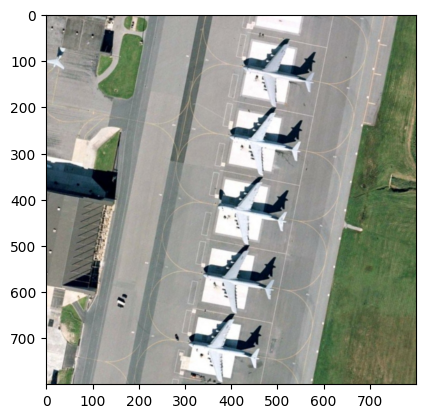

In [ ]:
import os
import gc
import itertools
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter, defaultdict
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import random
from tqdm.notebook import tqdm
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from ultralytics import YOLO

# lets use a fixed seed for the result consistency
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

data_dir = 'HawkEye/Data'

imfiles = os.listdir(os.path.join(data_dir, 'Images'))
imfiles = [os.path.join(data_dir, 'Images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)
print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

In order to verify if our images have same size I will iterate all of them and clasify by shape:

In [ ]:
# Dictionary to store the count of images for each shape
image_shapes = defaultdict(int)

for imfile in tqdm(imfiles):
    image = cv2.imread(imfile)
    if image is not None:
        shape = image.shape
        image_shapes[shape] += 1

# Iterate over all images and collect information about their shapes
for shape, count in image_shapes.items():
    print(f'Shape: {shape}, Count: {count}')

  0%|          | 0/3842 [00:00<?, ?it/s]

As we can see there is a big veriety of the image shapes yet the main claster is Shape: (800, 800, 3), Count: 3167. This will be the base of our dataset:

In [ ]:
# Function to read annotations
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations

def read_data(file_names, data_dir):
    data = []
    labels = []
    dims = []

    for file_name in file_names:
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')
        img = Image.open(img_path)

        if img.size != (800, 800):
            continue

        annotations = read_annotations(xml_path)

        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, xml_path, (width, height)))

    return data, labels, dims

file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]
data, labels, dims = read_data(file_names, data_dir)

Lets display some more of the random samples from our dataset, already with proper annotations:

In [ ]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(data) - 1)
    img_path, xml_path, _ = data[idx]
    img = Image.open(img_path)
    annotations = read_annotations(xml_path)
    draw = ImageDraw.Draw(img)

    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 20
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

I would like to visualise some additional properties of the dataset we will work with:

In [ ]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()

In [ ]:
# Print the per-class distribution
sorted_hist = dict(sorted(hist.items()))
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

In [ ]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

In [ ]:
# Brightness distribution per class for the sample
sample_labels = [data[idx][2][0][0] for idx in sample_data_indices]  # Fixed to access annotations correctly
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()

I am a bit worried by severely unequal per-class distribution and would like to mitigate the risks of some classes undertraining. At first I decided that simplest pass would be to remove overepresented classes. Lets take maximum of 500 images of each class.

In [ ]:
# Counter to count instances of each class
class_counter = Counter(labels)
max_count = 500

def filter_data(data, class_counter, max_count):
    new_data = []
    new_class_counter = {class_name: 0 for class_name in class_counter}
    for img_path, xml_path, dimensions in data:
        annotations = read_annotations(xml_path)
        filtered_annotations = []
        for annot in annotations:
            class_name = annot[0]
            if new_class_counter[class_name] < max_count:
                filtered_annotations.append(annot)
                new_class_counter[class_name] += 1
        if filtered_annotations:
            new_data.append((img_path, xml_path, dimensions))
    return new_data

filtered_data = filter_data(data, class_counter, max_count)

# Update labels based on filtered_data
new_labels = []
for img_path, xml_path, dimensions in filtered_data:
    annotations = read_annotations(xml_path)
    for annot in annotations:
        new_labels.append(annot[0])

# Recount instances of each class in the new dataset
new_class_counter = Counter(new_labels)
sorted_new_class_counter = dict(sorted(new_class_counter.items()))

# Print new statistics
for class_label, count in sorted_new_class_counter.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 678 instances
Class A10: 508 instances
Class A11: 410 instances
Class A12: 507 instances
Class A13: 590 instances
Class A14: 756 instances
Class A15: 473 instances
Class A16: 605 instances
Class A17: 814 instances
Class A18: 125 instances
Class A19: 556 instances
Class A2: 600 instances
Class A20: 508 instances
Class A3: 507 instances
Class A4: 453 instances
Class A5: 511 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 506 instances
Class A9: 562 instances


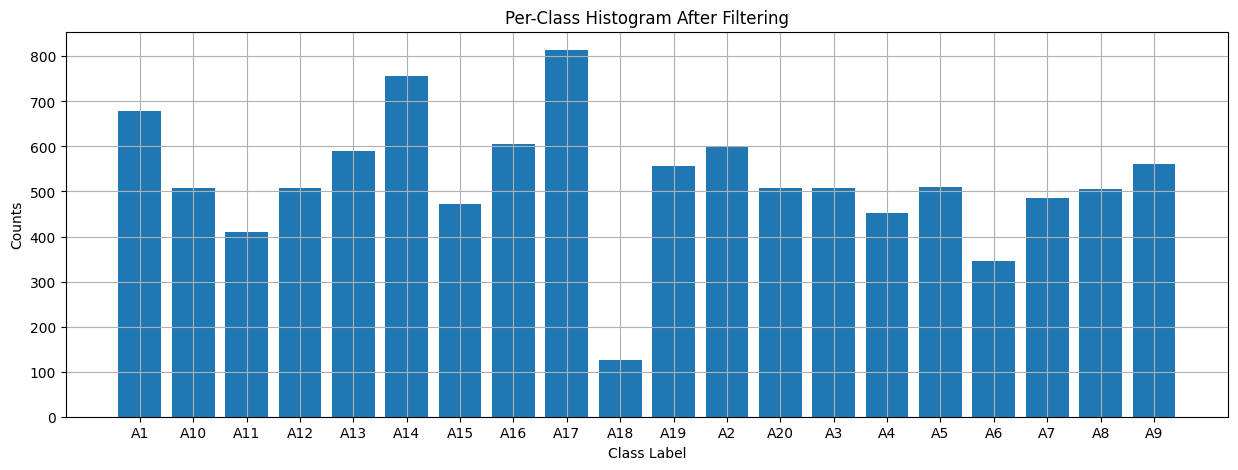

In [ ]:
# Plot the updated per-class histogram
plt.figure(figsize=(15, 5))
plt.bar(sorted_new_class_counter.keys(), sorted_new_class_counter.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram After Filtering')
plt.show()

In [ ]:
# Split data into training and validation sets
random.shuffle(data)
split_index = int(0.8 * len(data))
train_data = data[:split_index]
val_data = data[split_index:]

# Ensure paths in train.txt and test.txt are correct
train_files = [os.path.join(data_dir, 'Images', f"{os.path.splitext(os.path.basename(x[0]))[0]}.jpg") for x in train_data]
val_files = [os.path.join(data_dir, 'Images', f"{os.path.splitext(os.path.basename(x[0]))[0]}.jpg") for x in val_data]

# Write paths to image and XML annotation files
def write_data_to_file(data, file_path):
    with open(file_path, 'w') as f:
        for img_path, xml_path, _ in data:
            f.write(f"{img_path} {xml_path}\n")

# Use new file names for image-annotation pairs to avoid overwriting
write_data_to_file(train_data, os.path.join(data_dir, 'DataLists', 'train.txt'))
write_data_to_file(val_data, os.path.join(data_dir, 'DataLists', 'test.txt'))

# YOLO

In [ ]:
import shutil

# Create directories for YOLO dataset
yolo_base_dir = '/content/datasets/dataset'
train_img_dir = os.path.join(yolo_base_dir, 'train/images')
train_lbl_dir = os.path.join(yolo_base_dir, 'train/labels')
val_img_dir = os.path.join(yolo_base_dir, 'val/images')
val_lbl_dir = os.path.join(yolo_base_dir, 'val/labels')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Function to copy files based on file path lists
def copy_files(file_list, img_dest, lbl_dest):
    with open(file_list, 'r') as f:
        lines = f.readlines()
        for line in lines:
            img_path, xml_path = line.strip().split()
            shutil.copy(img_path, img_dest)
            shutil.copy(xml_path, lbl_dest)

# Copy training and validation files
copy_files(os.path.join(data_dir, 'DataLists', 'train_files.txt'), train_img_dir, train_lbl_dir)
copy_files(os.path.join(data_dir, 'DataLists', 'test_files.txt'), val_img_dir, val_lbl_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'HawkEye/Data/DataLists/train_files.txt'

In [ ]:
# Create data.yaml with correct paths
data_yaml_content = f"""
train: {os.path.join(yolo_base_dir, 'train')}
val: {os.path.join(yolo_base_dir, 'val')}
nc: {len(set(labels))}
names: {list(set(labels))}
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [ ]:
# Train YOLO
yolo_model = YOLO('yolov5su.pt')
yolo_model.train(data='data.yaml', epochs=30, imgsz=800)

# Validate YOLO
yolo_results = yolo_model.val()
print(yolo_results)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

FileNotFoundError: [34m[1mtrain: [0mError loading data from /content/datasets/HawkEye/Data/DataLists/train.txt
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [ ]:
Faster R-CNN

In [ ]:
# Define data transforms
transform = T.Compose([
    T.ToTensor(),
    T.Resize((800, 800))
])

# Define function to prepare data for Faster R-CNN
def prepare_frcnn_data(data):
    images = []
    targets = []
    for img_path, annotations in data:
        img = Image.open(img_path).convert("RGB")
        img = transform(img)
        boxes = []
        labels = []
        for annot in annotations:
            label, (xmin, ymin, xmax, ymax) = annot
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_names.index(label) + 1)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        images.append(img)
        targets.append({"boxes": boxes, "labels": labels})
    return images, targets

# Prepare the data
class_names = list(sorted_new_class_counter.keys())
train_images, train_targets = prepare_frcnn_data(train_data)
val_images, val_targets = prepare_frcnn_data(validation_data)

# Define and train Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True, num_classes=len(class_names) + 1)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified for brevity)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in zip(train_images, train_targets):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {losses.item()}')

# Validation
model.eval()
with torch.no_grad():
    for images, targets in zip(val_images, val_targets):
        images = [img.to(device) for img in images]
        outputs = model(images)
        print(outputs)

RetinaNet

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn

# Load the pre-trained RetinaNet model
retinanet_model = retinanet_resnet50_fpn(pretrained=True)
num_classes = len(set(labels)) + 1  # +1 for background
in_features = retinanet_model.head.classification_head.conv[0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetHead(in_features, num_anchors, num_classes)

# Training RetinaNet
# Similar training and validation code here

EfficientDet

In [ ]:
!pip install -U effdet

from effdet import create_model
from effdet.evaluator import evaluate

# Load EfficientDet model
effdet_model = create_model('tf_efficientdet_d0', num_classes=len(set(labels)) + 1)

# Training and validation code for EfficientDet
# Similar training and validation code here

Evaluation of the models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Placeholder for storing evaluation results
evaluation_results = {}

# Function to evaluate a model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mAP = average_precision_score(y_val, y_pred, average='macro')
    return precision, recall, f1, mAP

# Evaluate CNN model
precision, recall, f1, mAP = evaluate_model(cnn_model, X_val, y_val)
evaluation_results['CNN'] = (precision, recall, f1, mAP)

# Evaluate YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Inference Time

In [ ]:
import time

# Function to measure inference time
def measure_inference_time(model, X_val):
    start_time = time.time()
    model.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

# Measure inference time for CNN model
inference_time_cnn = measure_inference_time(cnn_model, X_val)
evaluation_results['CNN'] += (inference_time_cnn,)

# Measure inference time for YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Conclusion

1. Good data is a key! Garbge in - garbage out
2. Basic CNN would not work for object detection and clasification, vasted time on that track